In [1]:
# Defining Libraries:

import mne
import numpy as np
from scipy.signal import welch, stft
from scipy.stats import skew, kurtosis, entropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
from itertools import cycle

In [2]:
# Defining File Paths:

file_participant_1 = 'Data/Participant_1.edf'
file_participant_2 = 'Data/Participant_2.edf'
file_participant_3 = 'Data/Participant_3.edf'
file_participant_4 = 'Data/Participant_4.edf'
file_participant_5 = 'Data/Participant_5.edf'
file_participant_6 = 'Data/Participant_6.edf'
file_participant_7 = 'Data/Participant_7.edf'
file_participant_8 = 'Data/Participant_8.edf'
file_participant_9 = 'Data/Participant_9.edf'
file_participant_10 = 'Data/Participant_10.edf'
file_participant_11 = 'Data/Participant_11.edf'
file_participant_12 = 'Data/Participant_12.edf'
file_participant_13 = 'Data/Participant_13.edf'

edf_data_files = [
    file_participant_1,
    file_participant_2,
    file_participant_3,
    file_participant_4,
    file_participant_5,
    file_participant_6,
    file_participant_7,
    file_participant_8,
    file_participant_9,
    file_participant_10,
    file_participant_11,
    file_participant_12,
    file_participant_13
]

In [3]:
# Remove Start, Finish and Breaks:

# Loading the first file to use as a reference for channel names:
reference_raw = mne.io.read_raw_edf(edf_data_files[0], preload = True)
reference_channels = reference_raw.info['ch_names']

raw_objects = []

# Define the segments of interest in seconds:
segments = [
    (30, 90),  # "I"
    (120, 180),  # "Yes"
    (210, 270),  # "No"
    (300, 360),  # "Want"
    (390, 450),  # "Help"
    (480, 540),  # "More"
    (570, 630),  # "That"
    (660, 720),  # "Stop"
    (750, 810),  # "Open"
    (840, 900)   # "Close"
]

for file_path in edf_data_files:
    print(f"Editing file: {file_path}...")
    raw = mne.io.read_raw_edf(file_path, preload = True)
    raw.pick_channels(reference_channels)
    
    # Create an empty list to store the segments:
    data_segments = []
    
    for start, end in segments:
        segment = raw.copy().crop(tmin=start, tmax=end)
        data_segments.append(segment)
    
    # Concatenate the segments:
    raw_concatenated = mne.concatenate_raws(data_segments)
    raw_objects.append(raw_concatenated)

Extracting EDF parameters from c:\Users\salib\OneDrive\Desktop\Masters Thesis Code\Data\Participant_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 117759  =      0.000 ...   919.992 secs...
Editing file: Data/Participant_1.edf...
Extracting EDF parameters from c:\Users\salib\OneDrive\Desktop\Masters Thesis Code\Data\Participant_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 117759  =      0.000 ...   919.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Editing file: Data/Participant_2.edf...
Extracting EDF parameters from c:\Users\salib\OneDrive\Desktop\Masters Thesis Code\Data\Participant_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 116479  =      0.000 ...   909.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Editing file:

In [4]:
# Displaying the Resulting Files after Segmentation:

raw_objects

[<RawEDF | Participant_1.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_2.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_3.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_4.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_5.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_6.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_7.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_8.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_9.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_10.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_11.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_12.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_13.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>]

In [5]:
# Concatenating all Loaded and Processed Files:

raw = mne.concatenate_raws(raw_objects)

In [6]:
# Function to Preprocess Raw Data:

def preprocess_raw_data(raw):

    print("STARTING PREPROCESSING: ")

    # Handling NaNs: Replace NaNs with the mean of the respective channel:
    raw_data = raw.get_data()

    for i in range(raw_data.shape[0]):
        nan_indices = np.isnan(raw_data[i])

        if np.any(nan_indices):
            mean_value = np.nanmean(raw_data[i])
            raw_data[i, nan_indices] = mean_value

    raw._data = raw_data

    print("\n")

    # Filtering: Bandpass filter between 0.5-30 Hz:
    raw.filter(0.5, 30., fir_design = 'firwin')

    print("\n")
    
    # Artifact Removal: Independent Component Analysis (ICA):
    ica = mne.preprocessing.ICA(n_components = 14, random_state = 97, max_iter = 800)
    ica.fit(raw)
    raw = ica.apply(raw)

    print("\n")
    
    # Spatial Filtering: Common Average Reference (CAR):
    raw.set_eeg_reference('average', projection = True)

    print("\n")
    
    # Channel Interpolation: Interpolate bad channels
    raw.interpolate_bads()

    print("\n")

    # Baseline Correction: Apply baseline correction using the mean of the segment
    raw.apply_function(lambda x: x - np.mean(x), picks = 'eeg')

    print("\n")
    print("PREPROCESSING DONE!")
    
    return raw

In [7]:
# Preprocessing the Raw Data:

raw = preprocess_raw_data(raw)

STARTING PREPROCESSING: 


Filtering raw data in 130 contiguous segments
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (6.602 s)



Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 14 components
Fitting ICA took 8.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 60 PCA components


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


Setting channel interpolation method to {'eeg': 'spline'}.




PREPROCESSING DONE!


C:\Users\salib\AppData\Local\Temp\ipykernel_23044\3882312654.py:39: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()


In [8]:
# Creating Fixed-Length Epochs:

epoch_duration = 60  # seconds
start_times = np.arange(0, raw.times[-1] - epoch_duration, epoch_duration)
end_times = start_times + epoch_duration

In [9]:
# Displaying Epoch Start and End Times:

print("Start Times: ", start_times)
print("\nTotal Number of Start Times: ", len(start_times))
print("\n")
print("End Times: ", end_times)
print("\nTotal Number of End Times: ", len(end_times))

Start Times:  [   0.   60.  120.  180.  240.  300.  360.  420.  480.  540.  600.  660.
  720.  780.  840.  900.  960. 1020. 1080. 1140. 1200. 1260. 1320. 1380.
 1440. 1500. 1560. 1620. 1680. 1740. 1800. 1860. 1920. 1980. 2040. 2100.
 2160. 2220. 2280. 2340. 2400. 2460. 2520. 2580. 2640. 2700. 2760. 2820.
 2880. 2940. 3000. 3060. 3120. 3180. 3240. 3300. 3360. 3420. 3480. 3540.
 3600. 3660. 3720. 3780. 3840. 3900. 3960. 4020. 4080. 4140. 4200. 4260.
 4320. 4380. 4440. 4500. 4560. 4620. 4680. 4740. 4800. 4860. 4920. 4980.
 5040. 5100. 5160. 5220. 5280. 5340. 5400. 5460. 5520. 5580. 5640. 5700.
 5760. 5820. 5880. 5940. 6000. 6060. 6120. 6180. 6240. 6300. 6360. 6420.
 6480. 6540. 6600. 6660. 6720. 6780. 6840. 6900. 6960. 7020. 7080. 7140.
 7200. 7260. 7320. 7380. 7440. 7500. 7560. 7620. 7680. 7740.]

Total Number of Start Times:  130


End Times:  [  60.  120.  180.  240.  300.  360.  420.  480.  540.  600.  660.  720.
  780.  840.  900.  960. 1020. 1080. 1140. 1200. 1260. 1320. 1380. 1440.

In [10]:
# Defining the Words:

words = ['I', 'Yes', 'No', 'Want', 'Help', 'More', 'That', 'Stop', 'Open', 'Close']
print("Words: ", words)

Words:  ['I', 'Yes', 'No', 'Want', 'Help', 'More', 'That', 'Stop', 'Open', 'Close']


In [11]:
# Defining the Frequency:

sfreq = raw.info['sfreq']
print("Frequency Across Channels: ", sfreq, "Hz")

Frequency Across Channels:  128.0 Hz


In [12]:
# Feature Extraction Function:

def extract_features(epoch_data, sfreq):

    # Calculating Statistical Features:
    mean_vals = np.mean(epoch_data, axis = 1) # Mean value of the signal for each channel.
    std_vals = np.std(epoch_data, axis = 1) # Standard deviation of the signal for each channel.
    skew_vals = skew(epoch_data, axis = 1) # Skewness of the signal for each channel, indicating asymmetry.
    kurt_vals = kurtosis(epoch_data, axis = 1) # Kurtosis of the signal for each channel, indicating peakedness.

    # Power Spectral Density (PSD) Features:
    freqs, psd = welch(epoch_data, sfreq, nperseg = int(sfreq)) # Computes the PSD using Welch’s method.
    # Average power in the theta (4-8 Hz), alpha (8-12 Hz), and beta (12-30 Hz) frequency bands:
    theta_power = psd[:, (freqs > 4) & (freqs <= 8)].mean(axis = 1)
    alpha_power = psd[:, (freqs > 8) & (freqs <= 12)].mean(axis = 1)
    beta_power = psd[:, (freqs > 12) & (freqs <= 30)].mean(axis = 1)

    # Short-Time Fourier Transform (STFT) Features:
    _, _, Zxx = stft(epoch_data, fs = sfreq, nperseg = int(sfreq/2)) # Computes the STFT, which provides time-frequency representation of the signal.
    stft_power = np.abs(Zxx).mean(axis = 2) # Mean power from the STFT representation, averaged over time.
    
    # Entropy Feature:
    entropy_vals = np.array([entropy(np.abs(epoch_data[channel, :])) for channel in range(epoch_data.shape[0])]) # Computes the entropy of the signal for each channel, indicating the complexity or randomness of the signal.

    # Combining Features:
    features = np.stack([
        mean_vals,
        std_vals,
        skew_vals,
        kurt_vals,
        theta_power,
        alpha_power,
        beta_power,
        stft_power.mean(axis = 1),
        entropy_vals
    ], axis = 1) # Combines all extracted features into a single array with each feature as a column.

    return features

In [13]:
# Segmenting the Data into Epochs and Sub-Epochs:
# First -> 60 second epochs.
# Second -> 2 second sub-epochs.
# Third -> Extracting Features.

labeled_features_data = []
sub_epoch_duration = 2  # seconds

for i, (start, end) in enumerate(zip(start_times, end_times)): # Loops through each 30-second epoch:
    start_sample = int(start * sfreq)
    end_sample = int(end * sfreq)
    epoch_data, _ = raw[:, start_sample:end_sample] # Extracts the EEG data for the current epoch.
    word_label = words[i % len(words)] # Assigns a label to the current epoch using a list of predefined words.
    
    for j in range(int(epoch_duration / sub_epoch_duration)): # Iterate over Sub-Epochs:
        sub_start = j * sub_epoch_duration * int(sfreq)
        sub_end = (j + 1) * sub_epoch_duration * int(sfreq)
        sub_epoch_data = epoch_data[:, sub_start:sub_end]
        
        # Calls the extract_features function to extract from sub-epoch:
        features = extract_features(sub_epoch_data, sfreq)
        labeled_features_data.append((features, word_label)) # Stores the extracted features along with the label.

In [14]:
# Extracting Features and Labels:

features = np.array([f[0] for f in labeled_features_data])
labels = np.array([f[1] for f in labeled_features_data])

In [15]:
len(features)

3900

In [16]:
features

array([[[ 4.33698039e-07,  3.74146846e-07,  2.91355838e-01, ...,
          1.26739691e-16,  2.68528052e-08,  5.24296896e+00],
        [-1.33648244e-04,  3.74142901e-04, -2.91346154e-01, ...,
          1.26745537e-10,  2.07877867e-05,  5.29352889e+00],
        [ 4.33686776e-07,  3.74146846e-07,  2.91355838e-01, ...,
          1.26739691e-16,  2.68524529e-08,  5.24296825e+00],
        ...,
        [-6.84619722e-08,  2.39945575e-07,  6.40055641e-01, ...,
          8.72560979e-17,  1.14941632e-08,  5.21329278e+00],
        [ 6.64564392e-21,  2.12853227e-20, -3.70359079e-01, ...,
          5.41902348e-43,  1.37080249e-21,  5.41225607e+00],
        [ 6.62711301e-21,  2.13204387e-20, -3.69791833e-01, ...,
          5.42028055e-43,  1.37226149e-21,  5.41197918e+00]],

       [[ 2.91236864e-07,  2.84443201e-07, -4.57709203e-03, ...,
          1.26738884e-16,  2.01888295e-08,  5.26709492e+00],
        [ 8.80805151e-06,  2.84444027e-04,  4.56875200e-03, ...,
          1.26755145e-10,  1.68651487e

In [17]:
len(labels)

3900

In [18]:
labels

array(['I', 'I', 'I', ..., 'Close', 'Close', 'Close'], dtype='<U5')

In [19]:
# Preparing Data - Flattening & Scaling:

# Flattening the last two dimensions of the features array:
# To transform the 3D feature array into a 2D array where each row represents a single sample and each column represents a feature.
features_2d = features.reshape(features.shape[0], -1)

# Scaling the features:
# To standardise the features by scaling them so that they have a mean of 0 and a standard deviation of 1.
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_2d)

In [20]:
# Feature Set Preperation:

# Principal Component Analysis:
pca = PCA(n_components = 0.95) 
features_pca = pca.fit_transform(features_scaled)

# Mutual Information:
num_sub_epochs_per_epoch = int(epoch_duration / sub_epoch_duration)
total_sub_epochs = num_sub_epochs_per_epoch * len(start_times)

num_features = features_scaled.shape[1]
k_best = min(num_features, 20)  # Ensure k does not exceed the number of available features.
mi_selector = SelectKBest(mutual_info_classif, k = k_best)
features_mi = mi_selector.fit_transform(features_scaled, labels)

selected_features = features_mi # Choosing feature set to use for further model training.

num_features_mi = features_mi.shape[1]  # Number of features after MI

In [21]:
num_features_mi

20

In [22]:
num_features

540

In [23]:
k_best

20

In [24]:
# Creating Train, Test and Validation Sets:

train_features, test_features, train_labels, test_labels = train_test_split(
    selected_features, labels, test_size = 0.3, random_state = 42, stratify = labels)

val_features, test_features, val_labels, test_labels = train_test_split(
    test_features, test_labels, test_size = 0.5, random_state = 42, stratify = test_labels)

print("Total Dataset Size: ", (len(train_features) + len(val_features) + len(test_features)))
print("\n")
print(f"Training Data Size: {len(train_features)}")
print(f"Validation Data Size: {len(val_features)}")
print(f"Testing Data Size: {len(test_features)}")
print("\n")

# Counting occurrences of each label in the training, validation, and testing sets
train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)
test_label_counts = Counter(test_labels)

# Calculating the total number of samples in each set
total_train = len(train_labels)
total_val = len(val_labels)
total_test = len(test_labels)

# Printing the distribution of each label in each set
print("Training set label distribution:")
for label, count in train_label_counts.items():
    print(f"{label}: {count} ({count / total_train * 100:.2f}%)")

print("\nValidation set label distribution:")
for label, count in val_label_counts.items():
    print(f"{label}: {count} ({count / total_val * 100:.2f}%)")

print("\nTesting set label distribution:")
for label, count in test_label_counts.items():
    print(f"{label}: {count} ({count / total_test * 100:.2f}%)")

Total Dataset Size:  3900


Training Data Size: 2730
Validation Data Size: 585
Testing Data Size: 585


Training set label distribution:
Close: 273 (10.00%)
Yes: 273 (10.00%)
I: 273 (10.00%)
That: 273 (10.00%)
More: 273 (10.00%)
Want: 273 (10.00%)
No: 273 (10.00%)
Help: 273 (10.00%)
Stop: 273 (10.00%)
Open: 273 (10.00%)

Validation set label distribution:
Help: 59 (10.09%)
Close: 59 (10.09%)
That: 59 (10.09%)
No: 58 (9.91%)
Want: 59 (10.09%)
More: 58 (9.91%)
Stop: 58 (9.91%)
I: 58 (9.91%)
Open: 59 (10.09%)
Yes: 58 (9.91%)

Testing set label distribution:
Stop: 59 (10.09%)
Want: 58 (9.91%)
Help: 58 (9.91%)
Close: 58 (9.91%)
Yes: 59 (10.09%)
No: 59 (10.09%)
I: 59 (10.09%)
Open: 58 (9.91%)
More: 59 (10.09%)
That: 58 (9.91%)


In [25]:
# Designing Training Dataset:

class EEGDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype = torch.float32)
        self.labels = torch.tensor(labels, dtype = torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
# Encoding string labels to integers:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Print each label and its equivalent encoded label:
for label, encoded_label in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f'Label: {label}, Encoded: {encoded_label}')
    
train_dataset = EEGDataset(train_features, train_labels_encoded)
val_dataset = EEGDataset(val_features, val_labels_encoded)
test_dataset = EEGDataset(test_features, test_labels_encoded)

# Defining DataLoader:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Label: Close, Encoded: 0
Label: Help, Encoded: 1
Label: I, Encoded: 2
Label: More, Encoded: 3
Label: No, Encoded: 4
Label: Open, Encoded: 5
Label: Stop, Encoded: 6
Label: That, Encoded: 7
Label: Want, Encoded: 8
Label: Yes, Encoded: 9


In [26]:
# Define the CNN Architecture:

class CNNModel(nn.Module):
    def __init__(self, num_features, num_classes):

        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size = 2, stride = 2)
        
        self.conv2 = nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm1d(32)
        
        # Initialise the fully connected layer:
        self.fc1 = nn.Linear(32 * (num_features // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):

        x = x.unsqueeze(1) 
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        
        x = x.view(x.size(0), -1)  # Flatten the tensor.
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [27]:
# Define Training and Evaluation Functions:

def train(model, train_loader, criterion, optimizer, device):

    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    
    return epoch_loss, all_labels, all_preds

def evaluate(model, val_loader, criterion, device):

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():

        for inputs, labels in val_loader:

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc, all_labels, all_preds

In [28]:
# Preparing for Training:

# Set device to GPU if available:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_features = train_features.shape[1]
num_classes = len(np.unique(train_labels_encoded))

model = CNNModel(num_features, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Model Architecture:
summary(model, input_size = (1, num_features))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 10]                   --
├─Conv1d: 1-1                            [1, 16, 20]               64
├─BatchNorm1d: 1-2                       [1, 16, 20]               32
├─ReLU: 1-3                              [1, 16, 20]               --
├─MaxPool1d: 1-4                         [1, 16, 10]               --
├─Conv1d: 1-5                            [1, 32, 10]               1,568
├─BatchNorm1d: 1-6                       [1, 32, 10]               64
├─ReLU: 1-7                              [1, 32, 10]               --
├─MaxPool1d: 1-8                         [1, 32, 5]                --
├─Linear: 1-9                            [1, 128]                  20,608
├─ReLU: 1-10                             [1, 128]                  --
├─Linear: 1-11                           [1, 10]                   1,290
Total params: 23,626
Trainable params: 23,626
Non-trainable params: 0
Total

In [30]:
# Training Loop with Early Stopping:

num_epochs = 300
best_val_acc = 0.0
patience = 10
counter = 0

train_losses = []
val_losses = []
val_accuracies = []
train_metrics = []

for epoch in range(num_epochs):

    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_labels, train_preds = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_labels, val_preds = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict()
        torch.save(best_model_wts, 'Phase_1/Final_Models/CNN_Model.pth')  # Save the best model weights
        counter = 0  # Reset counter if validation accuracy improves
    else:
        counter += 1
    
    print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    if counter >= patience:
        print("Early stopping")
        break

model.load_state_dict(torch.load('Phase_1/Final_Models/CNN_Model.pth')) # Load best model weights

# Test the model during training:
test_loss, test_acc, test_labels, test_preds = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch 1/300
Train Loss: 2.1869, Val Loss: 2.1938, Val Acc: 0.2957
Epoch 2/300
Train Loss: 2.1018, Val Loss: 2.0974, Val Acc: 0.2991
Epoch 3/300
Train Loss: 2.0045, Val Loss: 1.9847, Val Acc: 0.3402
Epoch 4/300
Train Loss: 1.8857, Val Loss: 1.8638, Val Acc: 0.3915
Epoch 5/300
Train Loss: 1.7636, Val Loss: 1.7399, Val Acc: 0.4735
Epoch 6/300
Train Loss: 1.6309, Val Loss: 1.6186, Val Acc: 0.5060
Epoch 7/300
Train Loss: 1.5071, Val Loss: 1.5078, Val Acc: 0.5453
Epoch 8/300
Train Loss: 1.3857, Val Loss: 1.4131, Val Acc: 0.5641
Epoch 9/300
Train Loss: 1.2759, Val Loss: 1.3034, Val Acc: 0.6120
Epoch 10/300
Train Loss: 1.1742, Val Loss: 1.2224, Val Acc: 0.6615
Epoch 11/300
Train Loss: 1.0822, Val Loss: 1.1478, Val Acc: 0.7231
Epoch 12/300
Train Loss: 1.0014, Val Loss: 1.0682, Val Acc: 0.7179
Epoch 13/300
Train Loss: 0.9373, Val Loss: 1.0210, Val Acc: 0.7521
Epoch 14/300
Train Loss: 0.8626, Val Loss: 0.9661, Val Acc: 0.7744
Epoch 15/300
Train Loss: 0.7978, Val Loss: 0.9165, Val Acc: 0.7744
Epoc

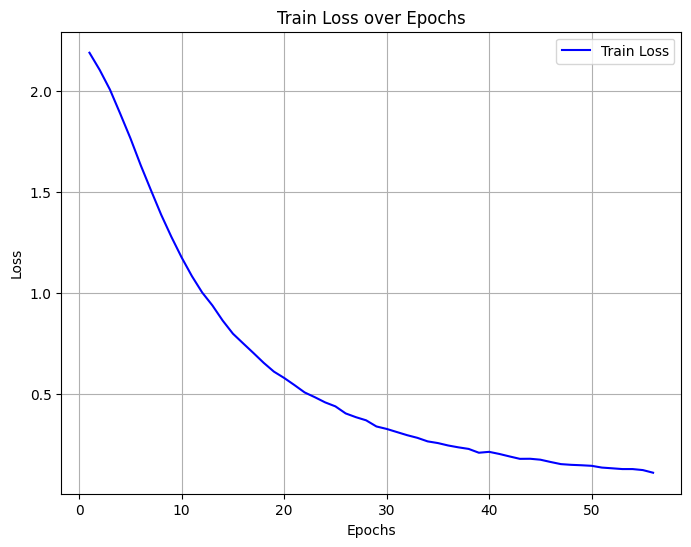

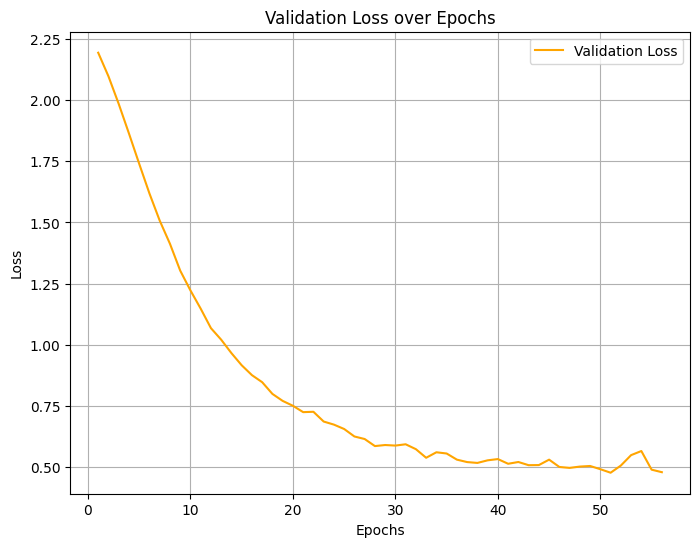

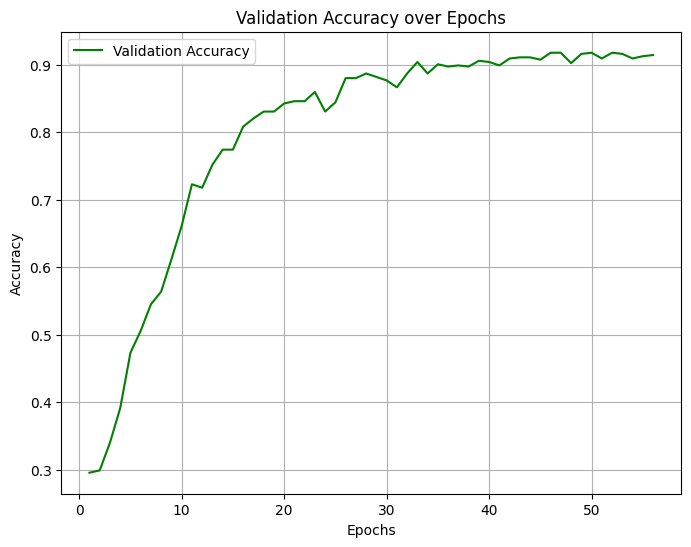

In [31]:
# Accuracy and Loss over Epochs:

epochs = range(1, len(train_losses) + 1)

# Train Loss:
plt.figure(figsize = (8, 6))
plt.plot(epochs, train_losses, label = 'Train Loss', color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Validation Loss:
plt.figure(figsize = (8, 6))
plt.plot(epochs, val_losses, label = 'Validation Loss', color = 'orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Validation Accuracy:
plt.figure(figsize = (8, 6))
plt.plot(epochs, val_accuracies, label = 'Validation Accuracy', color = 'green')
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Evaluation Function:

def calculate_metrics(labels, preds, dataset_name):

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average = 'weighted')
    recall = recall_score(labels, preds, average = 'weighted')
    f1 = f1_score(labels, preds, average = 'weighted')
    class_report = classification_report(labels, preds)
    conf_matrix = confusion_matrix(labels, preds)
    std_dev = np.std(preds)
    kappa = cohen_kappa_score(labels, preds)
    mcc = matthews_corrcoef(labels, preds)

    # Binarize the labels for ROC curve calculation
    n_classes = 10
    labels_binarized = label_binarize(labels, classes = range(n_classes))
    preds_binarized = label_binarize(preds, classes = range(n_classes))

    # Compute ROC curve and ROC area for each class:
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], preds_binarized[:, i])
        roc_auc[i] = roc_auc_score(labels_binarized[:, i], preds_binarized[:, i])

     # Compute Precision-Recall curve and PR area for each class:
    precision_curve = dict()
    recall_curve = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision_curve[i], recall_curve[i], _ = precision_recall_curve(labels_binarized[:, i], preds_binarized[:, i])
        average_precision[i] = average_precision_score(labels_binarized[:, i], preds_binarized[:, i])

    print(f'---------- {dataset_name} Evaluation Metrics: ----------\n')
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print("\n")

    print(f'Cohen\'s Kappa: {kappa:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print("\n")

    print('Classification Report:')
    print(class_report)
    print("\n")

    print('Confusion Matrix:')
    print("\n")
    plt.figure(figsize = (10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'Blues', xticklabels = words, yticklabels = words)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    print(f'Standard Deviation: {std_dev:.4f}\n')

    print("ROC Curve and AUC Scores: ")
    # Plot ROC curve
    plt.figure(figsize = (10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color = color, lw = 2,
                 label = f'ROC curve of class {words[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw = 2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset_name} ROC Curve')
    plt.legend(loc = "lower right")
    plt.show()

    print("Precision-Recall Curve: ")
    # Plot Precision-Recall curve
    plt.figure(figsize=(10, 7))
    for i, color in zip(range(n_classes), colors):
        plt.plot(recall_curve[i], precision_curve[i], color = color, lw = 2,
                 label=f'PR curve of class {words[i]} (area = {average_precision[i]:0.2f})')

    plt.plot([0, 1], [1, 0], 'k--', lw = 2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{dataset_name} Precision-Recall Curve')
    plt.legend(loc = "lower left")
    plt.show()

---------- Training Evaluation Metrics: ----------

Accuracy: 0.9853
Precision: 0.9854
Recall: 0.9853
F1-score: 0.9854


Cohen's Kappa: 0.9837
Matthews Correlation Coefficient: 0.9837


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       273
           1       0.98      0.99      0.99       273
           2       1.00      1.00      1.00       273
           3       0.99      0.98      0.99       273
           4       0.98      0.98      0.98       273
           5       1.00      0.98      0.99       273
           6       0.97      0.98      0.98       273
           7       0.97      0.97      0.97       273
           8       0.99      0.99      0.99       273
           9       0.99      0.98      0.99       273

    accuracy                           0.99      2730
   macro avg       0.99      0.99      0.99      2730
weighted avg       0.99      0.99      0.99      2730



Confusion Matrix:




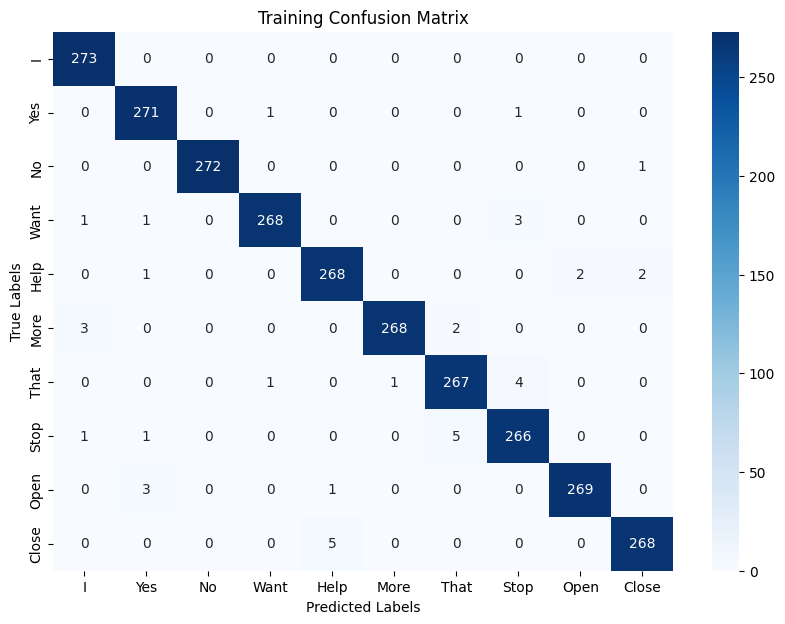

Standard Deviation: 2.8773

ROC Curve and AUC Scores: 


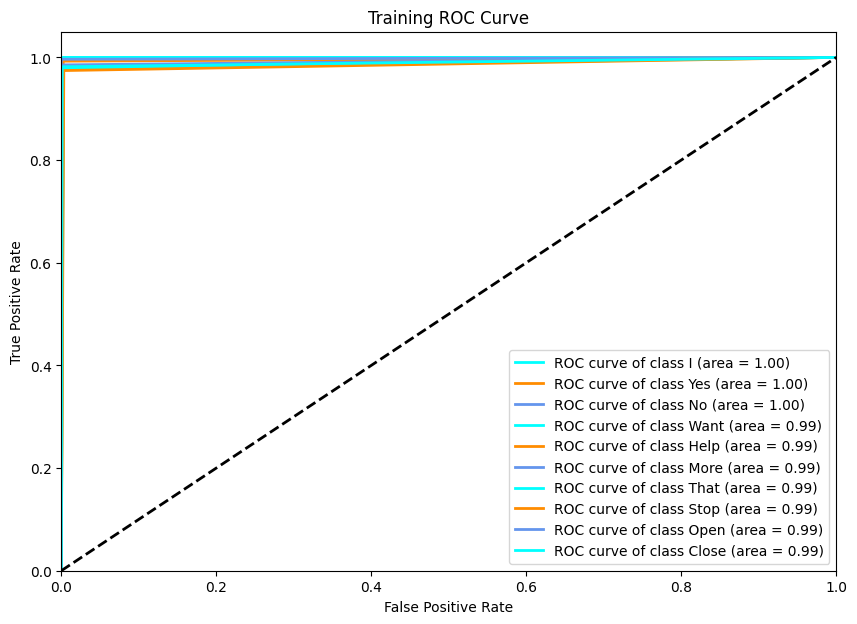

Precision-Recall Curve: 


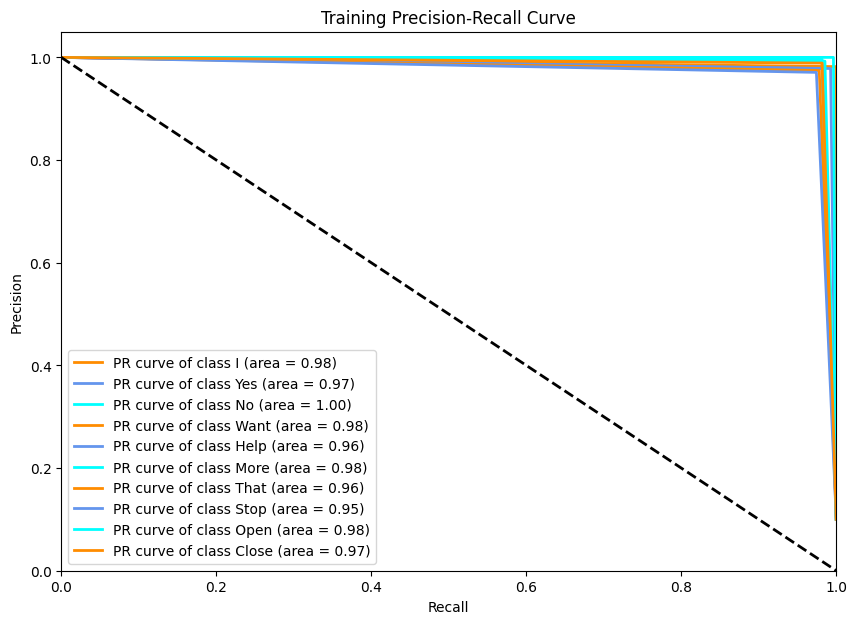

---------- Testing Evaluation Metrics: ----------

Accuracy: 0.9248
Precision: 0.9260
Recall: 0.9248
F1-score: 0.9249


Cohen's Kappa: 0.9164
Matthews Correlation Coefficient: 0.9165


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        58
           1       0.94      0.88      0.91        58
           2       0.88      0.95      0.91        59
           3       0.95      0.95      0.95        59
           4       0.90      0.92      0.91        59
           5       1.00      0.97      0.98        58
           6       0.93      0.90      0.91        59
           7       0.87      0.95      0.91        58
           8       0.91      0.90      0.90        58
           9       0.89      0.86      0.88        59

    accuracy                           0.92       585
   macro avg       0.93      0.92      0.92       585
weighted avg       0.93      0.92      0.92       585



Confusion Matrix:




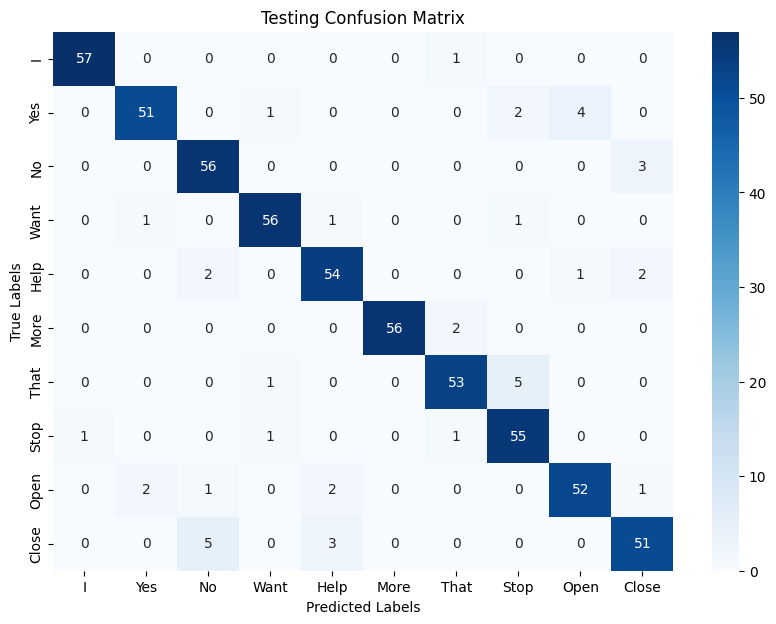

Standard Deviation: 2.8562

ROC Curve and AUC Scores: 


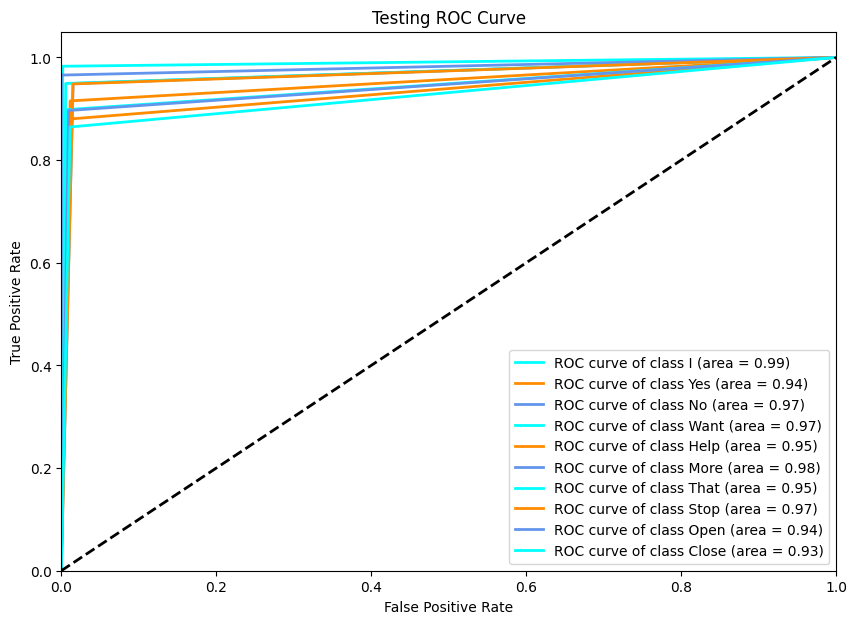

Precision-Recall Curve: 


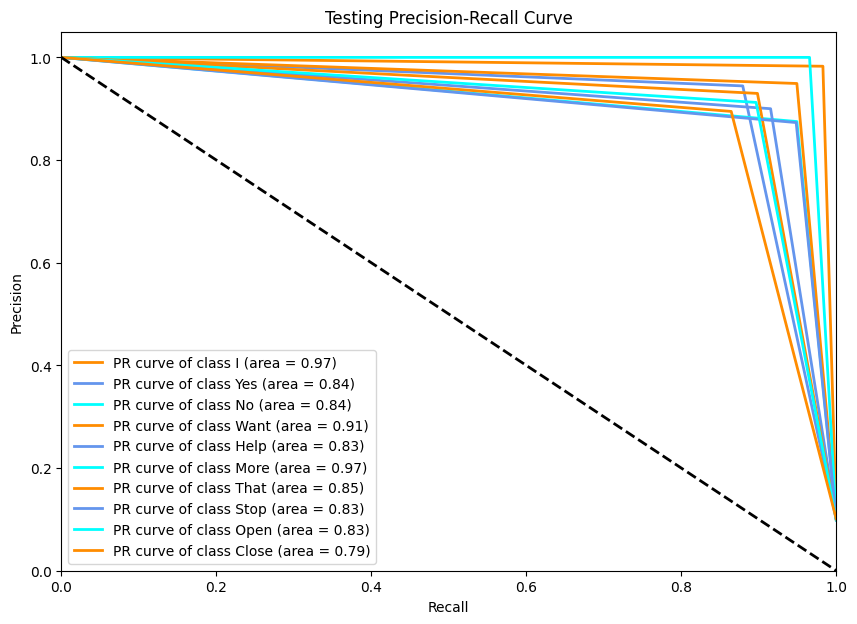

In [33]:
# Calculate metrics for the Training and Test Sets:

train_metrics = calculate_metrics(train_labels, train_preds, "Training")
test_metrics = calculate_metrics(test_labels, test_preds, "Testing")


In [34]:
# Real-time Predictions:

def predict(model, input_data, device):
    model.eval()
    input_data = torch.tensor(input_data, dtype=torch.float32).to(device)
    with torch.no_grad():
        output = model(input_data)
        _, predicted = torch.max(output.data, 1)
    return predicted.cpu().numpy()

# Load the trained model weights
model.load_state_dict(torch.load('Phase_1/Final_Models/CNN_Model.pth'))

# Example usage
sample_inputs = test_features[:10]  # Take five samples from the test set
actual_labels = test_labels[:10]

predicted_labels = predict(model, sample_inputs, device)

# Print actual vs predicted labels
for actual, predicted in zip(actual_labels, predicted_labels):
    print(f'Actual: {label_encoder.inverse_transform([actual])[0]}, Predicted: {label_encoder.inverse_transform([predicted])[0]}')

Actual: Stop, Predicted: Stop
Actual: Want, Predicted: Want
Actual: Help, Predicted: Help
Actual: Close, Predicted: Close
Actual: Help, Predicted: Help
Actual: Yes, Predicted: No
Actual: No, Predicted: No
Actual: I, Predicted: I
Actual: Open, Predicted: Open
Actual: No, Predicted: No


# Comment: Some Improvement - Dummy Testing.

import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset

# Step 1: Define the Number of Features and Classes
num_features = 20  # Number of features selected by Mutual Information
num_classes = 10   # Number of unique classes (words)
batch_size = 256   # Batch size used in the DataLoader

# Step 2: Create Dummy Data
num_samples = 1024
dummy_features = np.random.rand(num_samples, num_features)
dummy_labels = np.random.randint(0, num_classes, num_samples)

print(dummy_features)
# Step 3: Convert to Tensors and Create a Dataset
class DummyEEGDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

dummy_dataset = DummyEEGDataset(dummy_features, dummy_labels)
dummy_loader = DataLoader(dummy_dataset, batch_size=batch_size, shuffle=True)

# Step 4: Prepare the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming the model is already defined
# For example:
# model = EEGNet(num_features, num_classes).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# If you have saved model weights
# model.load_state_dict(torch.load('Best_CNN_Model.pth'))

model.to(device)

# Load the label encoder from the training phase
# Assuming the words are the same as defined in the training phase
words = ['Close', 'Help', 'I', 'More', 'No', 'Open', 'Stop', 'That', 'Want', 'Yes']
label_encoder = {i: word for i, word in enumerate(words)}

# Step 5: Classify One Sample
# Get a single sample from the dummy data
single_sample, true_label = dummy_dataset[0]
single_sample = single_sample.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Run the model on the single sample
model.eval()
with torch.no_grad():
    output = model(single_sample)

# Decode the output to get the predicted word
_, predicted_label = torch.max(output, 1)
predicted_word = label_encoder[predicted_label.item()]
true_word = label_encoder[true_label.item()]

print(f"True word: {true_word}")
print(f"Predicted word: {predicted_word}")
